# CBED with the PRISM algorithm

In [1]:
from ase.io import read
from ase.build import mx2
import matplotlib.pyplot as plt
import numpy as np

from abtem.plot import plot_atoms, plot_ctf
from abtem.waves import PrismWaves
from abtem.detect import RingDetector, FourierSpaceDetector
from abtem.potentials import Potential
from abtem.analyse import fwhm

Multslice STEM simulations can be quite slow, because the scattering of each new STEM probe is recomputed from scratch. An alternative is to use the multislice method to compute a scattering matrix, which is then used to construct each STEM probe. This algorithm often requires roughly the same computational time as the mutlislice method, but also allows for huge speed-ups by using Fourier interpolation of the scattering matrix. The algorithm called plane-wave recriprocal-space interpolated scattering matrix (PRISM) was created by Colin Ophus and Allan Pryor.

## Creating a SrTiO wedge
We import the Strontium Titanate crystal and repeat it as shown in lesson 1. Then we delete the upper left half of the crystal to leave behind a wedge.

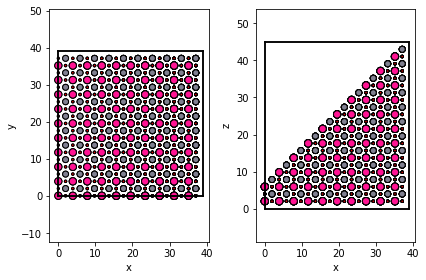

In [2]:
atoms = read('data/SrTiO.cif') # read atomic structure file
unit_cell = atoms.cell.copy()
atoms *= (10,10,12)
del atoms[atoms.positions[:,0] + 5 < atoms.positions[:,2]]

atoms.center(axis=2, vacuum=2)

fig,(ax1,ax2)=plt.subplots(1,2)
plot_atoms(atoms, ax=ax1)
plot_atoms(atoms, ax=ax2, plane='xz')
plt.tight_layout()

In [3]:
potential = Potential(atoms, sampling=.1, slice_thickness=1).precalculate(show_progress=False)

## Simulating the scattering matrix
The `PrismWaves` object is used to create the scattering matrix `S`. The scattering matrix is simply a Fourier expansion of the electron probe. In abTEM, the scattering matrix is a 3d matrix, where the first axis runs over plane waves of different wave vectors $(k_x, k_y)$ and the last two axes are the real space dimensions of the probe.

In [4]:
S = PrismWaves(energy=100e3, cutoff=.007, interpolation=1, sampling=.1).multislice(potential)

Below we plot slices of scattering matrix representing different plane waves of the plane wave expansion.

Scattering matrix shape: (177, 391, 391)


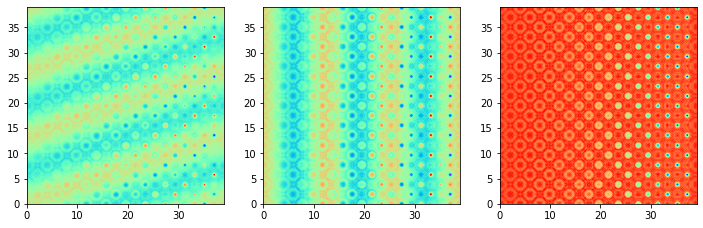

In [7]:
print('Scattering matrix shape:', S.array.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.imshow(S.array[70].real.T, extent=[0, S.extent[0], 0, S.extent[1]], cmap='rainbow')
ax2.imshow(S.array[len(S.array) // 4].real.T, extent=[0, S.extent[0], 0, S.extent[1]], cmap='rainbow')
ax3.imshow(S.array[len(S.array) // 2].real.T, extent=[0, S.extent[0], 0, S.extent[1]], cmap='rainbow');

To obtain the probe, we just do a coherent sum along the first axis of the scattering matrix.

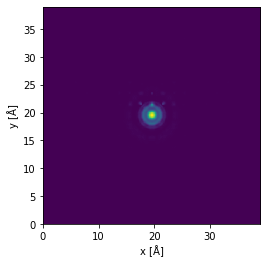

In [8]:
probe_array = S.array.sum(0)

plt.imshow(np.abs(np.fft.fftshift(probe_array))**2, extent=[0,S.extent[0],0,S.extent[1]])
plt.xlabel('x [Å]')
plt.ylabel('y [Å]');

Once the scattering matrix is calculated once, it is not necessary to recalculate it in order to change the CTF. 

In [9]:
S.cutoff = .007
S.rolloff = .2
S.defocus = 50
S.Cs = -1e7

The `ScatteringMatrix` object inherits from the `CTFBase`, hence we can plot its CTF as we did in previous lessons.

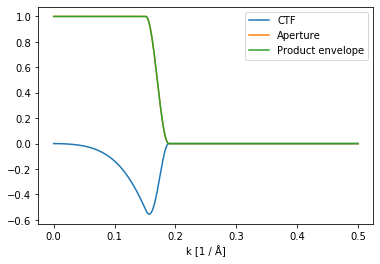

In [10]:
plot_ctf(S, max_k=.5)

## Scanning
The scattering matrix can be scanned using essentially the same methods as the `ProbeWaves` object. The only difference is that a potential does not have to be supplied.

In [12]:
detectors = [RingDetector(inner=.086, outer=.19), FourierSpaceDetector()]

scan = S.line_scan(detectors=detectors, start=(0,0), end=(atoms.cell[0,0], 0), sampling=0.5, max_batch=5,)

We plot the HAADF signal along the line scan.

Text(0.5, 0, 'x [Å]')

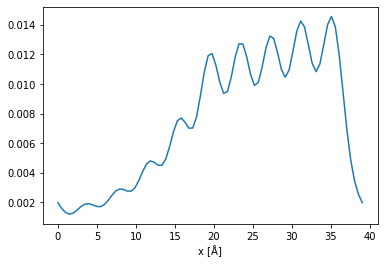

In [14]:
plt.plot(scan.get_positions()[:,0], scan.measurements[detectors[0]])
plt.xlabel('x [Å]')

We plot the Convergent Beam Electron Diffraction (CBED) pattern at 5 positions along the linescan.

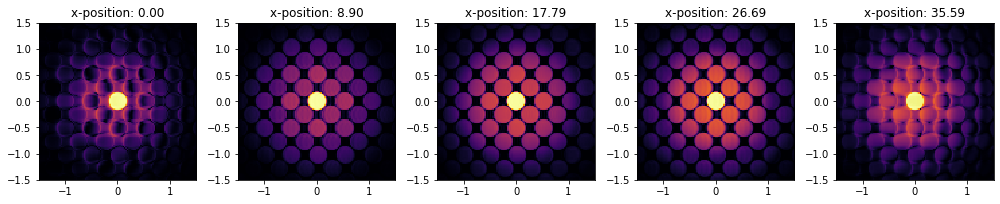

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(14,4))

for i in range(5):
    axes[i].imshow(np.log(1 + 1e-7 *  scan.measurements[detectors[1]][i*19]).T, 
               extent=detectors[1].fourier_limits.ravel(), cmap='inferno')
    axes[i].set_xlim([-1.5,1.5])
    axes[i].set_ylim([-1.5,1.5])
    axes[i].set_title('x-position: {:.2f}'.format(scan.get_positions()[i*18][0]))

plt.tight_layout()